In [21]:
### import math
import numpy as np
import math
import matplotlib.pyplot as plt
import torch
import random
%matplotlib inline

In [22]:
# derivatives from scratch
L = d * f

dL/dd = ? f # d's cancel leaving L/d = f since L = d * f ?

f(x+h)-f(x))/h

((d+h)*f - d*f)/h
(d*f + h*f - d*f) / h
(h*f)/h
f

SyntaxError: unmatched ')' (2542130677.py, line 6)

In [42]:
# value object data structure
# ._prev, ._op are autograd infrastructure

class Value:

    def __init__(self, data, _children=(), _op='', label=''): # i think 'self' is used to tie specific data to class instances
        self.data = data # assigns argument to specific instance of self
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children) # _children =() is an empty tuple turned into a 'set' within class
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data})" # print formatting

# use class operations to operate on class data
    # magic methods link __add__, __mul__ to +, * respectively

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other) # wraps other in Value object if isn't, allowing value + int/float
        out = Value(self.data + other.data, (self, other), '+') # essentially running a.__add__(b) -- a = self, b = other

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out

    def __pow__(self, other): # raising a value to power, other = power
        assert isinstance(other, (int, float)), "only supporting int/float powers"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data**(other - 1)) * out.grad
        out._backward = _backward

        return out

    def __rmul__(self, other): # allows other * self by checking if we can self * other (__mul__)
        return self * other

    def __radd__(self, other): # other + self
        return self + other

    def __truediv__(self, other):
        return self * other**-1 # ^-1 flips the base number i.e., 4 = 1/4^1 = .25

    def __neg__(self):
            return self *-1

    def __sub__(self, other):
            return self + (-other)
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tahn') # (self, ) is children node wrapped in tuple

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out

    def backward(self):
        
        topo = []
        visited = set() 
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

# (a.__mul__(b)).__add__(c) = a is the self who * other.data b > that value as self + other c
#d = (a.__add__(b)).__mul__(c)
#d

In [24]:
from graphviz import Digraph

def trace(root):
    # builds set of nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in graph, create rectangle ('record') node
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # op node created when value is result of operation
            dot.node(name = uid + n._op, label = n._op)
            # connect
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [25]:
a = Value(2.0)
b = Value(4.0)
a-b


Value(data=-2.0)

In [26]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 +  b; n.label = 'n' # n = cell body/neuron prior to act function
o = n.tanh(); o.label = 'o'
o.backward()

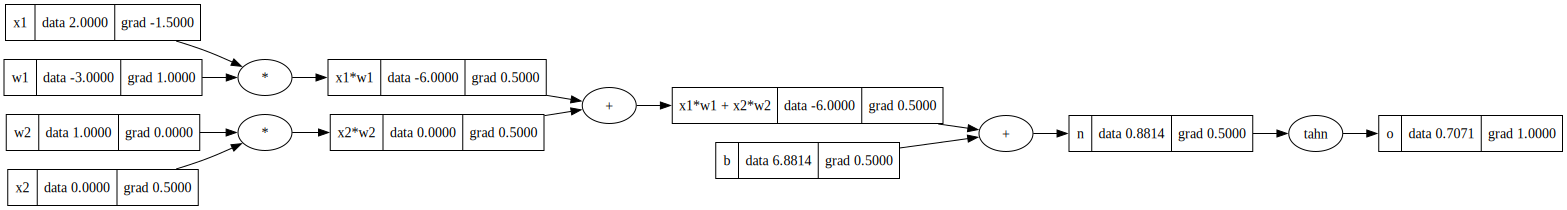

In [27]:
draw_dot(o)

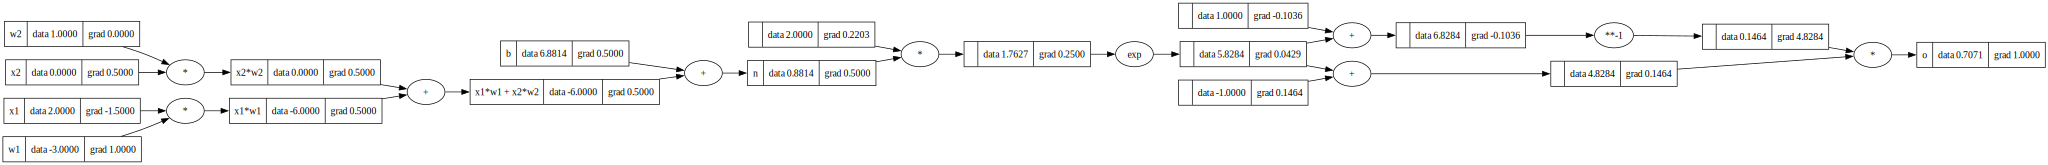

In [28]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 +  b; n.label = 'n' # n = cell body/neuron prior to act function
# ----
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ----
o.label = 'o'
o.backward()
draw_dot(o)

In [29]:
# topological sort, sorts graph from left to right
topo = []
visited = set() # set of visited nodes
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v) # adds self once all children added
build_topo(o) # starting at o, iterates through children
topo

[Value(data=2),
 Value(data=6.881373587019543),
 Value(data=2.0),
 Value(data=-3.0),
 Value(data=-6.0),
 Value(data=0.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=-6.0),
 Value(data=0.8813735870195432),
 Value(data=1.7627471740390863),
 Value(data=5.828427124746192),
 Value(data=1),
 Value(data=6.828427124746192),
 Value(data=0.1464466094067262),
 Value(data=-1),
 Value(data=4.828427124746192),
 Value(data=0.7071067811865477)]

In [30]:
o.backward()

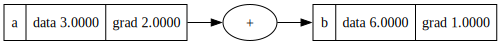

In [31]:
a = Value(3.0, label='a')
b = a + a ; b.label = 'b'
b.backward()
draw_dot(b)

In [32]:
import torch

In [39]:

x1 = torch.Tensor([2.0]).double()               ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()               ; x2.requires_grad = True 
w1 = torch.Tensor([-3.0]).double()              ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()               ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double() ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())


0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [58]:

class Neuron:
    def __init__(self, nin): # number of inputs to neuron = neuron dimension
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        # w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b) # zip pairs elements from 2 iterables; w's * x's
        out = act.tanh()
        return out

class Layer:

    def __init__(self, nin, nout): # nin = inputs per neuron; nout = # of neurons for layer
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs [0] if len(outs) == 1 else outs
        
class MLP:

    def __init__(self, nin, nouts): # nouts = list of number and size of layers
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x


x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1]) # 3 inputs[2 layers of 4 neurons and 1 output]
n(x)

Value(data=0.16535746269783408)

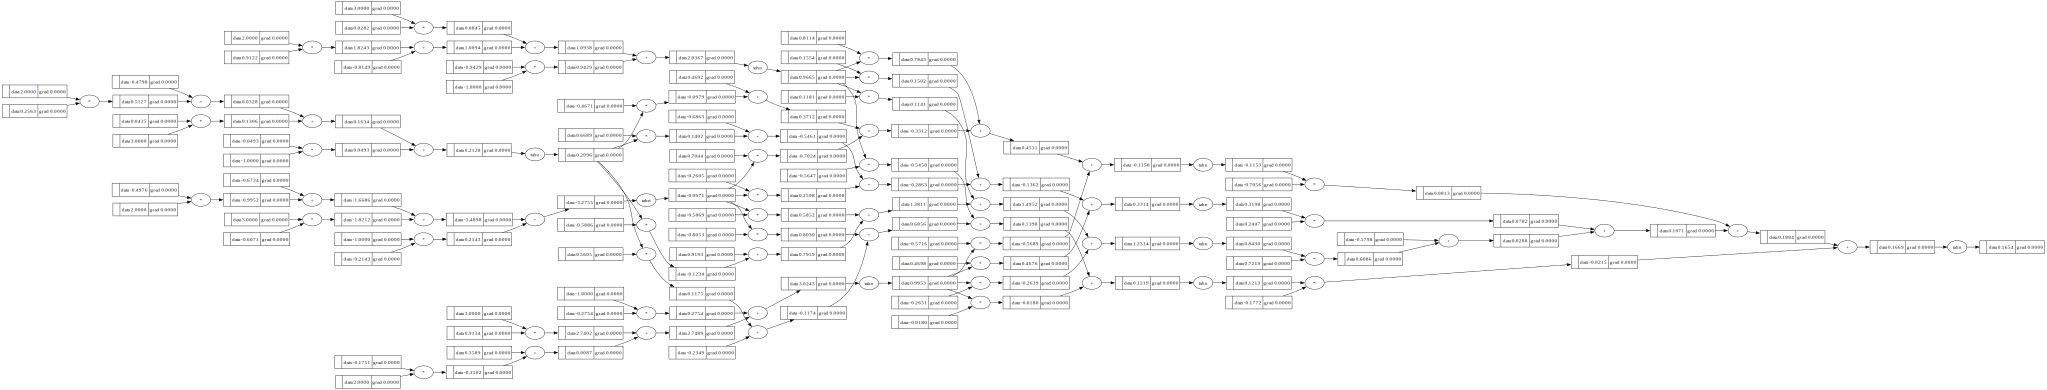

In [59]:
draw_dot(n(x))

In [60]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

_IncompleteInputError: incomplete input (805647701.py, line 1)